In [1]:
# --- Cell 1: Imports & Setup ---
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from tqdm import tqdm  
from scipy import stats 

plt.style.use('ggplot')

In [2]:
# --- Cell 2: Core Algorithm Framework ---

def dynamic_greedy_coloring(graph, priority_function, rule_name="Unknown"):
    """
    通用动态贪心着色算法框架
    
    参数:
        graph: networkx.Graph 对象
        priority_function: 函数, 签名 def func(node, graph, coloring) -> float
        rule_name: 用于记录日志的规则名称
    
    返回:
        coloring: 字典 {node: color_id}
        num_colors: 总色数
        execution_time: 耗时(秒)
    """
    start_time = time.time()
    
    coloring = {}
    nodes = list(graph.nodes())
    uncolored = set(nodes)
    
    max_steps = len(nodes)
    steps = 0
    
    while uncolored and steps < max_steps:
        try:
            best_node = max(uncolored, key=lambda n: priority_function(n, graph, coloring))
        except Exception as e:
            # 容错机制：如果 LLM 的规则报错（如除以零），回退到度数最大
            best_node = max(uncolored, key=lambda n: graph.degree[n])

        # 获取邻居已经使用的颜色集合
        neighbor_colors = {coloring[nbr] for nbr in graph.neighbors(best_node) if nbr in coloring}
        
        # 寻找 MEX (Minimum Excluded value)
        color = 0
        while color in neighbor_colors:
            color += 1
            
        coloring[best_node] = color
        uncolored.remove(best_node)
        steps += 1
        
    end_time = time.time()
    return coloring, max(coloring.values()) + 1, end_time - start_time

In [3]:
# --- Cell 3: Baseline Heuristics ---

def heuristic_random(node, graph, coloring):
    """基准 1: 随机选择 (下界)"""
    return random.random()

def heuristic_welsh_powell(node, graph, coloring):
    """基准 2: Welsh-Powell (静态度数优先)"""
    # 优先着色度数大的点
    return graph.degree[node]

def heuristic_dsatur(node, graph, coloring):
    """基准 3: DSatur (动态饱和度优先)"""
    # 计算饱和度：已着色邻居的颜色种类数量
    neighbor_colors = {coloring[nbr] for nbr in graph.neighbors(node) if nbr in coloring}
    saturation = len(neighbor_colors)
    
    # DSatur 的 Tie-breaking 规则：如果饱和度相同，选度数大的
    return saturation * 10000 + graph.degree[node]

print("基准规则定义完毕：Random, Welsh-Powell, DSatur")

基准规则定义完毕：Random, Welsh-Powell, DSatur


In [4]:
# --- Cell 4: The Ultimate Showdown ---

import math
import networkx as nx
from collections import Counter

# Generation 1: 原始复杂逻辑 (Restored Original)

def heuristic_gpt_v1_topology_original(node, graph, coloring):
    """[GPT v1 Original] 原始的线性加权策略"""
    if coloring.get(node) is not None: return -1e9

    neighbors = list(graph.neighbors(node))
    deg = len(neighbors)
    n_nodes = graph.number_of_nodes()

    neighbor_colors = [coloring.get(n) for n in neighbors if coloring.get(n) is not None]
    saturation = len(set(neighbor_colors))

    uncolored_neighbors = sum(1 for n in neighbors if coloring.get(n) is None)
    uncolored_ratio = (uncolored_neighbors / deg) if deg > 0 else 0.0

    try: clust = nx.clustering(graph, node)
    except: clust = 0.0

    avg_neighbor_deg = 0.0
    if deg > 0:
        total = sum(graph.degree(nbr) for nbr in neighbors)
        avg_neighbor_deg = total / deg

    second_order = set()
    for nbr in neighbors:
        for v in graph.neighbors(nbr):
            if v != node and v not in neighbors:
                second_order.add(v)
    second_norm = len(second_order) / max(n_nodes - deg - 1, 1)

    return (3.0 * saturation + 
            1.2 * (uncolored_ratio * deg) + 
            0.7 * ((1.0 - clust) * avg_neighbor_deg) + 
            0.9 * math.log1p(len(second_order)) * second_norm)

def heuristic_grok_v1_product_original(node, graph, coloring):
    """[Grok v1 Original] 原始的复杂乘积策略"""
    neighbors = list(graph.neighbors(node))
    if not neighbors: return 0.0
    colored = [n for n in neighbors if coloring.get(n) is not None]
    sat = len(set(coloring[n] for n in colored)) if colored else 0
    deg = graph.degree(node)
    
    neighbor_degrees = [graph.degree(n) for n in neighbors]
    avg_nd = sum(neighbor_degrees) / len(neighbors) if neighbors else 0.0
    
    second_order = set()
    for n in neighbors:
        second_order.update(graph.neighbors(n))
    second_order.discard(node)
    second_order.difference_update(neighbors)
    
    try: cc = nx.clustering(graph, node)
    except: cc = 0.0
    
    return (sat * avg_nd) + (len(second_order)/(deg+1)) / (cc + 0.1)

# Generation 2: 分层逻辑 (The Current Champion)

def heuristic_gpt_v2_tiered(node, graph, coloring):
    """[GPT v2] 饱和度主导 + 未来连通性"""
    if coloring.get(node) is not None: return -1e12
    neighbors = list(graph.neighbors(node))
    
    # Layer 1: Saturation
    neighbor_colors = [coloring.get(v) for v in neighbors if coloring.get(v) is not None]
    saturation = len(set(neighbor_colors))
    primary = float(saturation) * 1e8  

    # Layer 2: Tie-breakers
    uncolored = [v for v in neighbors if coloring.get(v) is None]
    if not uncolored: return primary + len(neighbors)
    
    # Feature: Future High Degree
    neigh_degs = [graph.degree(v) for v in uncolored]
    avg_deg = sum(neigh_degs)/len(neigh_degs) if neigh_degs else 0
    high_deg_count = sum(1 for d in neigh_degs if d > avg_deg)
    
    return primary + high_deg_count * 10 + len(neighbors)

# Generation 3: 前瞻策略

def heuristic_gpt_v3_lookahead(node, graph, coloring):
    """
    V3 版本：Future Connectivity Impact（未来连通性影响）启发式
    -------------------------------------------------------------------
    Score = saturation(node) * 1e8
            + Σ_{v in UncoloredNeighbors(node)}  ( saturation(v)^2 )

    核心动机：
      - primary 仍以 saturation 决定整体排序
      - tie-breaking 通过 look-ahead：观察该节点未着色邻居的 saturation
        若邻居本身已高度饱和（危险节点），则 node 的优先级显著提高。

    复杂度：
      - saturation(node) 计算 O(deg(node))
      - 对每个未着色邻居 v，计算 saturation(v) 是 O(deg(v))
      - 总体复杂度为 O( sum(deg(v)) )，在着色器中完全可接受。

    参数：
      node: 当前要评估的节点（未着色）
      graph: NetworkX 图
      coloring: dict，coloring[u] = color 或 None
    """

    # 若节点已着色，给极低分（不再选择）
    if coloring.get(node) is not None:
        return float(-1e15)

    #  1. 计算自身的 saturation
    neighbors = list(graph.neighbors(node))
    neighbor_colors = [coloring.get(v) for v in neighbors if coloring.get(v) is not None]
    saturation = len(set(neighbor_colors))

    # primary = saturation * 1e8
    primary = float(saturation) * 1e8

    # 2. 未来连通性影响：未着色邻居的 saturation^2 
    lookahead_sum = 0.0

    for v in neighbors:
        if coloring.get(v) is None:  # 仅对未着色邻居计算 look-ahead
            # v 的饱和度：其邻居中不同已用颜色数
            sat_v = 0
            for w in graph.neighbors(v):
                c = coloring.get(w)
                if c is not None:
                    pass
            sat_colors = set()
            for w in graph.neighbors(v):
                cw = coloring.get(w)
                if cw is not None:
                    sat_colors.add(cw)
            sat_v = len(sat_colors)

            # 加入平方项
            lookahead_sum += sat_v * sat_v

    # 最终得分
    return primary + lookahead_sum

# Generation 4: 危机感知
def heuristic_gpt_v4_crisis(node, graph, coloring):
    """
    Crisis-Aware DSatur (V4)

    Score = Saturation(node) * 1e9 + sum_{v in UncoloredNeighbors(node)} Crisis(v)
    Crisis(v) = Saturation(v) / (ResidualDegree(v) + 1)

    - coloring: dict mapping node -> color (None or missing => uncolored)
    - 使用局部遍历：对每个未着色邻居 v 只遍历一次其邻域以同时计算 Sat(v) 与 ResidualDegree(v)
    - 若 node 已被着色，返回非常小的值避免再次选中。
    """

    # 已着色的节点不应被再次选择
    if coloring.get(node) is not None:
        return float(-1e18)

    coloring_get = coloring.get
    neighbors_u = list(graph.neighbors(node))

    # 1 计算 node 的 saturation
    sat_colors_u = set()
    for w in neighbors_u:
        cw = coloring_get(w)
        if cw is not None:
            sat_colors_u.add(cw)
    saturation_u = len(sat_colors_u)

    # Primary：绝对主导项
    primary = float(saturation_u) * 1e9

    # 2 对每个未着色邻居 v，计算 Crisis(v) = Sat(v) / (ResidualDegree(v) + 1)
    total_crisis = 0.0

    has_uncolored_neighbor = False
    for v in neighbors_u:
        if coloring_get(v) is None:
            has_uncolored_neighbor = True
            break
    if not has_uncolored_neighbor:
        return primary

    # 对未着色邻居进行计算：单次遍历其邻域以同时获取 Sat(v) 与 ResidualDegree(v)
    for v in neighbors_u:
        if coloring_get(v) is not None:
            continue  # 跳过已着色邻居

        sat_colors_v = set()
        residual_v = 0  # 未着色邻居计数

        for w in graph.neighbors(v):
            cw = coloring_get(w)
            if cw is None:
                # 未着色的邻居
                residual_v += 1
            else:
                sat_colors_v.add(cw)

        sat_v = len(sat_colors_v)
        # 按定义计算危机度并累加
        total_crisis += (sat_v / (residual_v + 1))

    # 最终评分
    return primary + float(total_crisis)

# Generation 5: 融合策略
def heuristic_gpt_v5_hybrid(node, graph, coloring):
    """
    V5: Squared Crisis Lookahead (hybrid of V3 & V4)

    Score = saturation(node) * 1e9
            + sum_{v in UncoloredNeighbors(node)} ( Sat(v)^2 / (ResidualDegree(v) + 1) )

    - coloring: dict mapping node -> color (None or missing => uncolored)
    - Performance: for each uncolored neighbor v we do a single pass over v's adjacency
      to collect its saturation (set of distinct neighbor colors) and its residual degree
      (count of uncolored neighbors). Uses graph.adj[v] for faster neighbor iteration.
    - If node already colored, returns a very small value.
    """

    coloring_get = coloring.get
    adj = graph.adj  
    
    if coloring_get(node) is not None:
        return float(-1e18)

    sat_colors_u = set()
    neighbors_u = list(adj[node])
    for w in neighbors_u:
        cw = coloring_get(w)
        if cw is not None:
            sat_colors_u.add(cw)
    saturation_u = len(sat_colors_u)

    primary = float(saturation_u) * 1e9

    has_uncolored = False
    for v in neighbors_u:
        if coloring_get(v) is None:
            has_uncolored = True
            break
    if not has_uncolored:
        return primary

    total_tie = 0.0

    for v in neighbors_u:
        if coloring_get(v) is not None:
            continue  # s

        sat_colors_v = set()
        residual_v = 0  

        for w in adj[v]:
            cw = coloring_get(w)
            if cw is None:
                # w is uncolored
                residual_v += 1
            else:
                # w is colored -> contributes to saturation of v
                sat_colors_v.add(cw)

        sat_v = len(sat_colors_v)
        # formula: (Sat(v)^2) / (ResidualDegree(v) + 1)
        # ResidualDegree includes node (if uncolored) as well as other uncolored neighbors
        denom = (residual_v + 1)
        # safe division (denom >= 1 always)
        total_tie += (sat_v * sat_v) / denom

    # 最终评分
    return primary + float(total_tie)


# 注册表

rules_registry = [
    ("DSatur", heuristic_dsatur),              # 基准
    ("GPT-v1 (Original)", heuristic_gpt_v1_topology_original), 
    ("Grok-v1 (Original)", heuristic_grok_v1_product_original),
    ("GPT-v2 (Tiered)", heuristic_gpt_v2_tiered),   
    ("GPT-v3 (Lookahead)", heuristic_gpt_v3_lookahead), 
    ("GPT-v4 (Crisis)", heuristic_gpt_v4_crisis),
    ("GPT-v5 (Hybrid)", heuristic_gpt_v5_hybrid),
]

print(">>> 五代算法集结完毕！")

>>> 五代算法集结完毕！


In [5]:
# --- Cell 5: Advanced Dataset Generation ---

from scipy.spatial import Delaunay
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm

# 显式导入 mycielskian_graph
from networkx.generators.mycielski import mycielski_graph

def create_random_planar_graph(n):
    """生成随机平面图"""
    points = np.random.rand(n, 2)
    tri = Delaunay(points)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for path in tri.simplices:
        nx.add_path(G, path)
        nx.add_path(G, [path[-1], path[0]])
    return G

def generate_datasets(main_sample_size=500, special_sample_size=30, node_count=60): 
    """
    生成全方位的测试数据集
    main_sample_size: 主流随机图的数量 (100-500)
    special_sample_size: 特殊图的数量 (30-50)
    """
    datasets = {
        # --- 基础组 (Baseline) ---
        "Planar": [],
        "Random_Sparse (p=0.1)": [],
        "Random_Dense (p=0.5)": [],
        
        # --- 进阶组 (Advanced) ---
        "Scale_Free (Barabasi)": [],  # 模拟真实世界
        "Mycielskian (Trap)": [],     # 理论陷阱
        "Bipartite (Sanity)": []      # 完整性检查
    }
    
    print("正在构建测试集 (这可能需要几分钟)...")
    
    # 1. 基础组生成
    for _ in tqdm(range(main_sample_size), desc="Generating Main Datasets"):
        datasets["Planar"].append(create_random_planar_graph(node_count))
        
        while True:
            G = nx.erdos_renyi_graph(node_count, 0.1)
            if nx.is_connected(G):
                datasets["Random_Sparse (p=0.1)"].append(G)
                break
                
        while True:
            G = nx.erdos_renyi_graph(node_count, 0.5)
            if nx.is_connected(G):
                datasets["Random_Dense (p=0.5)"].append(G)
                break
                
    # 2. 进阶组生成 
    for _ in tqdm(range(special_sample_size), desc="Generating Special Datasets"):
        
        # A. 无标度网络 (Barabasi-Albert)
        # m=3 表示每个新节点连接 3 个旧节点
        G_sf = nx.barabasi_albert_graph(node_count, 3)
        datasets["Scale_Free (Barabasi)"].append(G_sf)
        
        # B. 米切尔斯基图 (Mycielskian) - 理论陷阱
        G_myc = mycielski_graph(5) 
        datasets["Mycielskian (Trap)"].append(G_myc)
        
        # C. 二部图 (Bipartite)
        # 左右各一半节点
        n_left = node_count // 2
        n_right = node_count - n_left
        G_bi = nx.bipartite.random_graph(n_left, n_right, 0.3)
        # 保证连通性
        while not nx.is_connected(G_bi):
             G_bi = nx.bipartite.random_graph(n_left, n_right, 0.3)
        datasets["Bipartite (Sanity)"].append(G_bi)
        
    print(f"数据集构建完成! \n基础图: {main_sample_size}个/类 \n特殊图: {special_sample_size}个/类")
    return datasets

# 执行生成
datasets = generate_datasets(main_sample_size=500, special_sample_size=30, node_count=60)

正在构建测试集 (这可能需要几分钟)...


Generating Main Datasets:   0%|          | 0/500 [00:00<?, ?it/s]

Generating Special Datasets:   0%|          | 0/30 [00:00<?, ?it/s]

数据集构建完成! 
基础图: 500个/类 
特殊图: 30个/类


In [6]:
# --- Cell 6: Experiment Execution ---

results = []

print("开始运行对比实验...")

for category, graphs in datasets.items():
    print(f"正在测试图类型: {category} ...")
    
    for G in tqdm(graphs):
        # 计算图的一些基本属性，用于后续分析
        max_degree = max(dict(G.degree()).values()) # Brooks 定理上界
        # clique_number = nx.graph_clique_number(G) 
        
        for rule_name, rule_func in rules_registry:
            # 运行算法
            coloring, num_colors, exec_time = dynamic_greedy_coloring(G, rule_func, rule_name)
            
            # 验证合法性 (Defensive Programming)
            is_valid = all(coloring[u] != coloring[v] for u, v in G.edges())
            if not is_valid:
                print(f"ERROR: Rule {rule_name} produced invalid coloring!")
            
            # 记录结果
            results.append({
                "Category": category,
                "Rule": rule_name,
                "Colors": num_colors,
                "Time": exec_time,
                "Nodes": len(G.nodes()),
                "Edges": len(G.edges()),
                "Max_Degree": max_degree
            })

# 转换为 DataFrame 方便分析
df_results = pd.DataFrame(results)
print("\n实验结束！预览数据：")
print(df_results.head())

开始运行对比实验...
正在测试图类型: Planar ...


  0%|          | 0/500 [00:00<?, ?it/s]

正在测试图类型: Random_Sparse (p=0.1) ...


  0%|          | 0/500 [00:00<?, ?it/s]

正在测试图类型: Random_Dense (p=0.5) ...


  0%|          | 0/500 [00:00<?, ?it/s]

正在测试图类型: Scale_Free (Barabasi) ...


  0%|          | 0/30 [00:00<?, ?it/s]

正在测试图类型: Mycielskian (Trap) ...


  0%|          | 0/30 [00:00<?, ?it/s]

正在测试图类型: Bipartite (Sanity) ...


  0%|          | 0/30 [00:00<?, ?it/s]


实验结束！预览数据：
  Category                Rule  Colors      Time  Nodes  Edges  Max_Degree
0   Planar              DSatur       5  0.001002     60    167           9
1   Planar   GPT-v1 (Original)       5  0.029956     60    167           9
2   Planar  Grok-v1 (Original)       5  0.020495     60    167           9
3   Planar     GPT-v2 (Tiered)       4  0.004404     60    167           9
4   Planar  GPT-v3 (Lookahead)       4  0.006738     60    167           9


=== 实验结果汇总表 ===
                 Category                Rule     Colors                Time
                                                    mean       std      mean
0      Bipartite (Sanity)              DSatur   2.000000  0.000000  0.001067
1      Bipartite (Sanity)   GPT-v1 (Original)   2.433333  0.727932  0.040221
2      Bipartite (Sanity)     GPT-v2 (Tiered)   2.000000  0.000000  0.004604
3      Bipartite (Sanity)  GPT-v3 (Lookahead)   2.000000  0.000000  0.009419
4      Bipartite (Sanity)     GPT-v4 (Crisis)   2.000000  0.000000  0.006574
5      Bipartite (Sanity)     GPT-v5 (Hybrid)   2.000000  0.000000  0.007683
6      Bipartite (Sanity)  Grok-v1 (Original)   3.366667  1.033352  0.033157
7      Mycielskian (Trap)              DSatur   5.000000  0.000000  0.000163
8      Mycielskian (Trap)   GPT-v1 (Original)   5.000000  0.000000  0.003896
9      Mycielskian (Trap)     GPT-v2 (Tiered)   5.000000  0.000000  0.000590
10     Mycielskian (Trap)  GPT-v3 (Lookahead)   5.000000  0.

C:\Users\yuanzhouyan\AppData\Local\Temp\ipykernel_5168\1403720819.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes1[i].boxplot(data_to_plot, labels=rules)
C:\Users\yuanzhouyan\AppData\Local\Temp\ipykernel_5168\1403720819.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes1[i].boxplot(data_to_plot, labels=rules)
C:\Users\yuanzhouyan\AppData\Local\Temp\ipykernel_5168\1403720819.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes1[i].boxplot(data_to_plot, labels=rules)


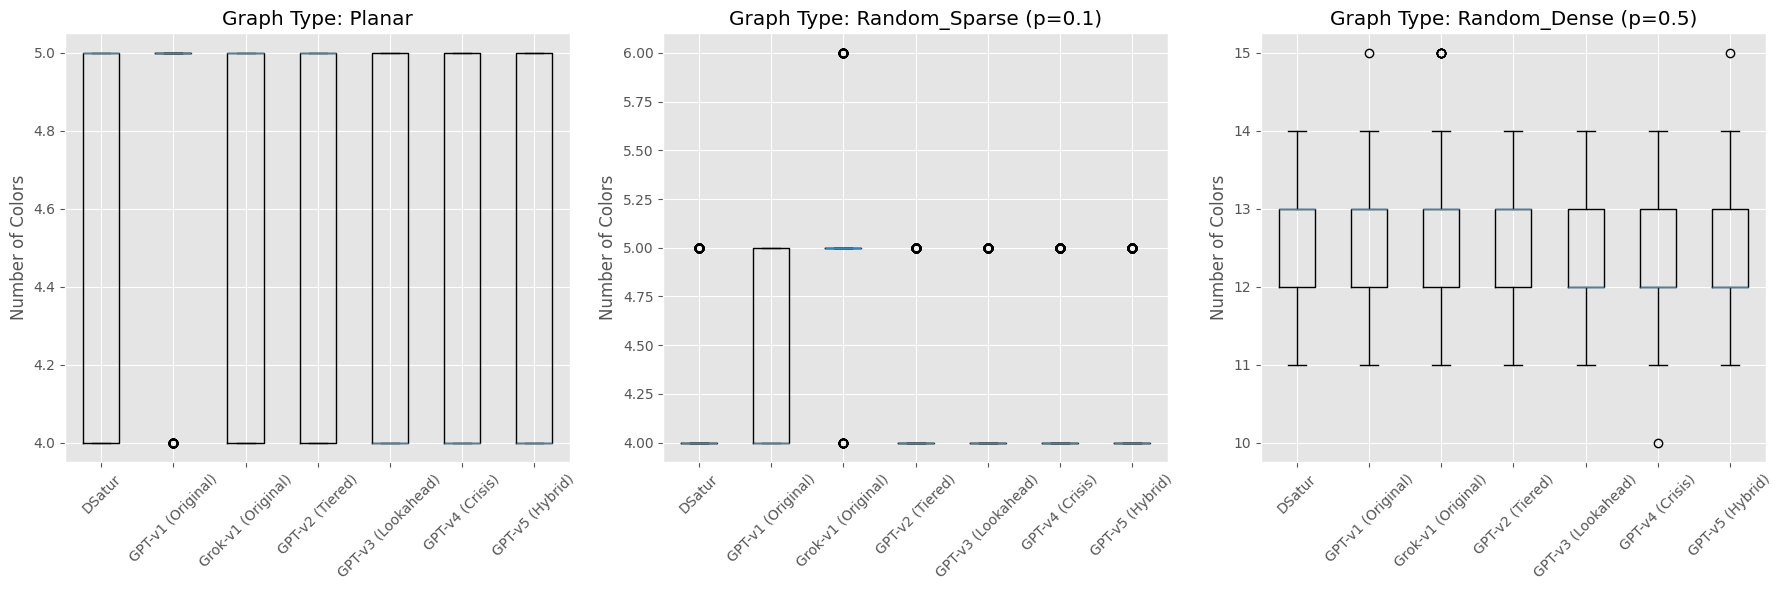

C:\Users\yuanzhouyan\AppData\Local\Temp\ipykernel_5168\1403720819.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes2[i].boxplot(data_to_plot, labels=rules)
C:\Users\yuanzhouyan\AppData\Local\Temp\ipykernel_5168\1403720819.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes2[i].boxplot(data_to_plot, labels=rules)
C:\Users\yuanzhouyan\AppData\Local\Temp\ipykernel_5168\1403720819.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes2[i].boxplot(data_to_plot, labels=rules)


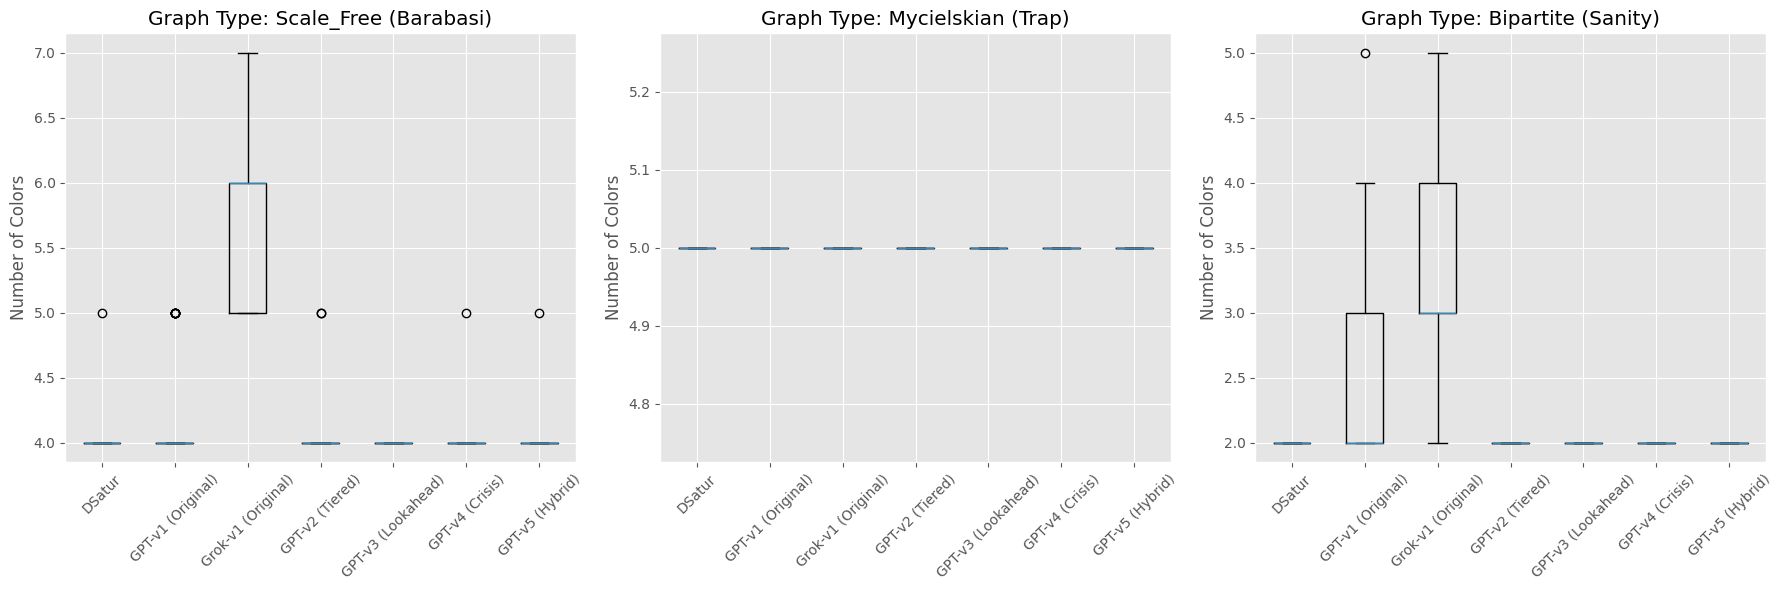

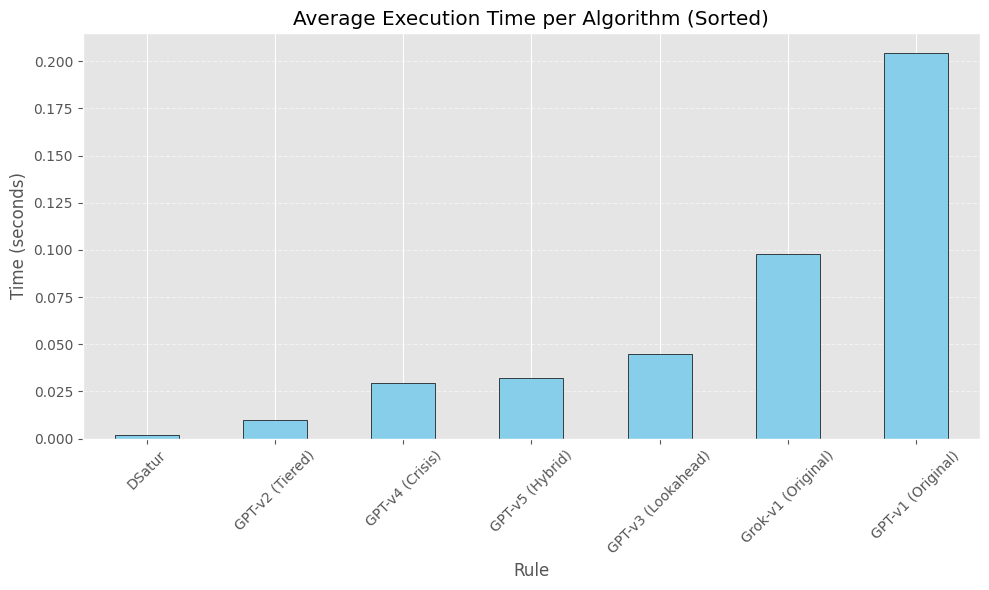

正在可视化平面图着色结果 (Nodes: 60)...


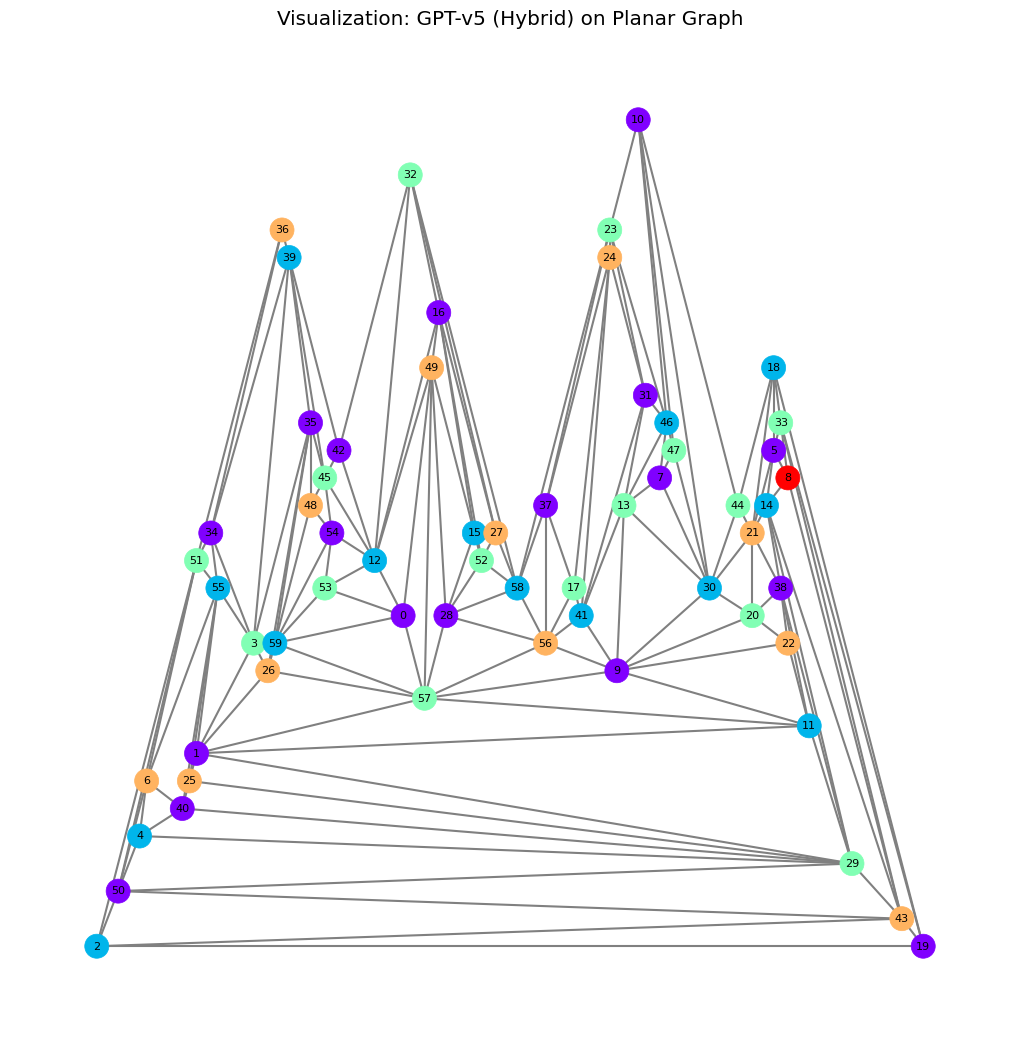

In [ ]:
# --- Cell 7: Analysis & Visualization ---

# 1. 汇总统计表
summary = df_results.groupby(["Category", "Rule"]).agg({
    "Colors": ["mean", "std"],
    "Time": ["mean"]
}).reset_index()

print("=== 实验结果汇总表 ===")
print(summary)

# 2. 绘制柱状图 (色数对比 - 箱线图)
rules = df_results["Rule"].unique()
group1 = ["Planar", "Random_Sparse (p=0.1)", "Random_Dense (p=0.5)"]
group2 = ["Scale_Free (Barabasi)", "Mycielskian (Trap)", "Bipartite (Sanity)"]

# 第一个图 (group1)
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
for i, cat in enumerate(group1):
    subset = df_results[df_results["Category"] == cat]
    data_to_plot = [subset[subset["Rule"] == r]["Colors"].values for r in rules]
    axes1[i].boxplot(data_to_plot, labels=rules)
    axes1[i].set_title(f"Graph Type: {cat}")
    axes1[i].set_ylabel("Number of Colors")
    axes1[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 第二个图 (group2)
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
for i, cat in enumerate(group2):
    subset = df_results[df_results["Category"] == cat]
    data_to_plot = [subset[subset["Rule"] == r]["Colors"].values for r in rules]
    axes2[i].boxplot(data_to_plot, labels=rules)
    axes2[i].set_title(f"Graph Type: {cat}")
    axes2[i].set_ylabel("Number of Colors")
    axes2[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 3. 绘制时间对比图
fig2, ax2 = plt.subplots(figsize=(10, 6))
time_data = df_results.groupby("Rule")["Time"].mean()
time_data.sort_values().plot(kind='bar', color='skyblue', ax=ax2, edgecolor='black')
ax2.set_title("Average Execution Time per Algorithm (Sorted)")
ax2.set_ylabel("Time (seconds)")
ax2.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. 案例可视化 
try:
    # 选取一个平面图进行展示
    sample_graph = datasets["Planar"][0]
    print(f"正在可视化平面图着色结果 (Nodes: {len(sample_graph.nodes)})...")

    coloring, _, _ = dynamic_greedy_coloring(sample_graph, heuristic_gpt_v5_hybrid, "GPT-v5") 
    
    node_colors = [coloring[n] for n in sample_graph.nodes()]

    plt.figure(figsize=(10, 10))
    try:
        pos = nx.planar_layout(sample_graph)
    except:
        pos = nx.spring_layout(sample_graph, seed=42)
        
    nx.draw(sample_graph, pos, 
            node_color=node_colors, 
            cmap=plt.cm.rainbow, 
            with_labels=True, 
            node_size=300, 
            edge_color='gray',
            width=1.5,
            font_size=8)
            
    plt.title("Visualization: GPT-v5 (Hybrid) on Planar Graph")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"可视化错误: {e}")